In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [47]:

# Load and preprocess the data
df = pd.read_csv('./archiveweather/GlobalLandTemperaturesByCountry.csv', parse_dates=['dt'], index_col='dt')
df = df[df['Country'] == 'Poland']
df = df[df.index > '1900-12-31']
df = df.drop('Country', axis=1)
df.dropna(inplace=True)


In [48]:

# Split the data into training and testing sets
train_size = int(len(df) * 0.67)
train, test = df.iloc[0:train_size], df.iloc[train_size:]


In [49]:

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train[['AverageTemperature']]) # Fit only on training data
train_scaled = scaler.transform(train[['AverageTemperature']])
test_scaled = scaler.transform(test[['AverageTemperature']]) # Apply to test data


In [50]:

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train_scaled, look_back)
testX, testY = create_dataset(test_scaled, look_back)


In [51]:

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=64, verbose=2, validation_data=(testX, testY))


Epoch 1/100
15/15 - 1s - loss: 0.3227 - val_loss: 0.2052 - 1s/epoch - 79ms/step
Epoch 2/100
15/15 - 0s - loss: 0.1268 - val_loss: 0.0649 - 37ms/epoch - 2ms/step
Epoch 3/100
15/15 - 0s - loss: 0.0530 - val_loss: 0.0478 - 41ms/epoch - 3ms/step
Epoch 4/100
15/15 - 0s - loss: 0.0497 - val_loss: 0.0448 - 38ms/epoch - 3ms/step
Epoch 5/100
15/15 - 0s - loss: 0.0467 - val_loss: 0.0452 - 36ms/epoch - 2ms/step
Epoch 6/100
15/15 - 0s - loss: 0.0464 - val_loss: 0.0438 - 36ms/epoch - 2ms/step
Epoch 7/100
15/15 - 0s - loss: 0.0455 - val_loss: 0.0431 - 35ms/epoch - 2ms/step
Epoch 8/100
15/15 - 0s - loss: 0.0448 - val_loss: 0.0425 - 36ms/epoch - 2ms/step
Epoch 9/100
15/15 - 0s - loss: 0.0442 - val_loss: 0.0420 - 43ms/epoch - 3ms/step
Epoch 10/100
15/15 - 0s - loss: 0.0436 - val_loss: 0.0412 - 36ms/epoch - 2ms/step
Epoch 11/100
15/15 - 0s - loss: 0.0429 - val_loss: 0.0407 - 37ms/epoch - 2ms/step
Epoch 12/100
15/15 - 0s - loss: 0.0423 - val_loss: 0.0399 - 36ms/epoch - 2ms/step
Epoch 13/100
15/15 - 0s - 

In [52]:

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))


14/14 [==============================] - 0s 702us/step
Train Score: 2.63 RMSE
Test Score: 2.80 RMSE


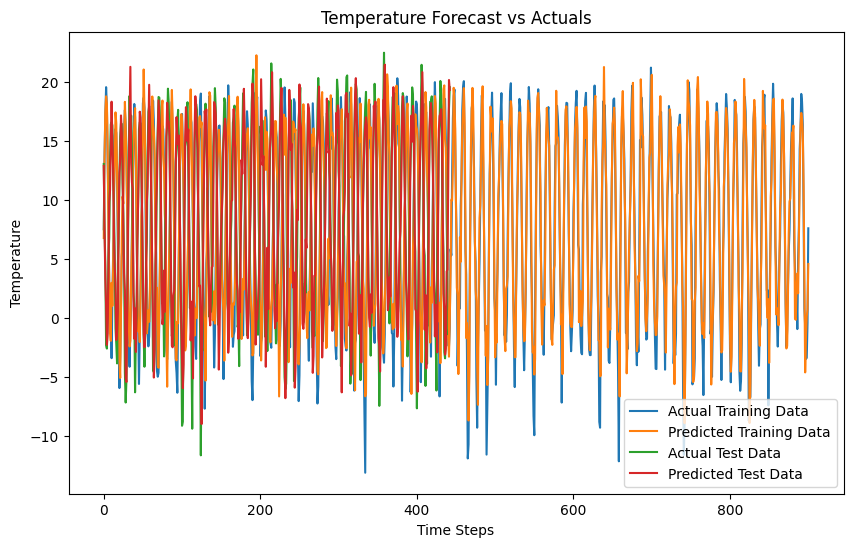

In [53]:

# Plot baseline and predictions
plt.figure(figsize=(10,6))
plt.plot(trainY[0], label='Actual Training Data')
plt.plot(trainPredict[:,0], label='Predicted Training Data')
plt.plot(testY[0], label='Actual Test Data')
plt.plot(testPredict[:,0], label='Predicted Test Data')
plt.title('Temperature Forecast vs Actuals')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()
